# Winner Prediction

This notebook builds a model for predicting the winner of a match between two players. Prediction models for tennis matches can take a variety of forms (see [An Introduction to Tennis Modelling](https://www.betfair.com.au/hub/an-introduction-to-tennis-modelling/)). 

Predictions based solely on Elo rating have proven very successful. We will use such predictions as our baseline model. Specifically, we'll use the pre-match Elo ratings we calculated in a previous notebook to create predictions for each match in the data. Note that we'll restrict our work to data after 1991 so that we can leverage the detail match statistics from past matches. 

We'll build on predicitons solely from Elo ratings by incorporating these ratings into models that also use player and match statistics, including previous head-to-head matches. The idea is to see whether  such a model can capture some of the information relevant to predicting the winner that is not captured in the Elo ratings. This could be things like handedness, height, age, playing surface, summary statistics from recent matches, and the players history in head-to-head matches.   

We start with preliminaries. 

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV

from google.colab import drive
drive.mount('/content/drive')

import pickle
with open('/content/drive/My Drive/ATP Tennis/Database/ATP_Pickle.pickle','rb') as f:
    atp_pickle = pickle.load(f)

We pull in the match data and adda date field that we'll use later.

In [2]:
all_matches = atp_pickle[0]
import datetime
all_matches["year"] = [int(np.floor(i/10000)) for i in all_matches["tourney_date"].values]
all_matches['monthday'] = all_matches['tourney_date'] - all_matches['year']*10000
all_matches['month'] = [int(np.floor(i/100)) for i in all_matches['monthday']]
all_matches['day'] = all_matches['monthday'] - all_matches['month']*100
all_matches['date'] = [datetime.date(year=i,day=j,month=k) for i,j,k in zip(all_matches['year'],all_matches['day'],all_matches['month'])]
all_matches['date'] = pd.to_datetime(all_matches['date'])

Next, we limit the data to observations that seem reliable and have all the data that we might want. See the data cleaning and exploration notebooks for more information on these restrictions. We end up with ~81,000 matches from 1991 - 2020. 

In [3]:
matches = all_matches[all_matches["year"]>=1991]
matches = matches[(matches["NoDetailStats"]==0) & 
            (matches["Davis_Cup"]==0) & 
            (matches["NoMinutes"]==0) & 
            (matches["NoWinnerRank"]==0) & 
            (matches["NoLoserRank"]==0) & 
            (matches["NoWinnerRankPoints"]==0) & 
            (matches["NoLoserRankPoints"]==0)]
matches.shape

(81287, 89)

**Elo Only Predictions**

We start by predicting the match winners using just the pre-match Elo ratings from all surfaces. The probabilities of winning are calculated in the same way as they were for calculating the Elo ratings themselves. 

$$\begin{aligned}
\mathbb{P}(\text{Player A Wins}) &= \frac{1}{1+10^{(\text{Rating}_B - \text{Rating}_A)/400}} \\
\mathbb{P}(\text{Player B Wins}) &= \frac{1}{1+10^{(\text{Rating}_A - \text{Rating}_B)/400}} = 1-\mathbb{P}(\text{Player A Wins})
\end{aligned}$$

We'll calculate the probability that the player who ended up winning would win based on the pre-match rating. We can then summarize how many matches are correctly predicted by seeing how many matches there are where the actual winner had a better than 50% probability of winning based on the pre-match ratings. 

We see that this method does very well, as expected, we see that with just the pre-match Elo ratings we're able to predict about 66.01% of matches correctly.

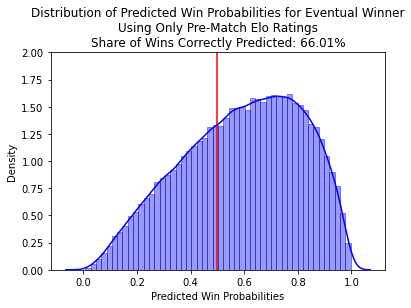

In [4]:
EloPredictions = 1.0 / (1 + 10**((matches["PreMatchElo_Loser_All"] - matches["PreMatchElo_Winner_All"]) / 400))
CorrectPct = round(EloPredictions[EloPredictions>0.5].count() / EloPredictions.count()*100,2)
sns.distplot(EloPredictions, hist=True, kde=True, bins=50, color = 'blue', hist_kws={'edgecolor':'darkblue'})
plt.vlines(0.5,0,2,colors="red")
plt.ylim(0,2)
plt.title("Distribution of Predicted Win Probabilities for Eventual Winner\nUsing Only Pre-Match Elo Ratings\nShare of Wins Correctly Predicted: "+str(CorrectPct)+"%")
plt.xlabel("Predicted Win Probabilities")
plt.ylabel("Density")
plt.show()

When we use a mix of Elo ratings from all surfaces and for the specific surface of the match, we see only incremental improvement. Below I show a 50-50 mix but I tried many other versions and none perform better. Its interesting to note that even using just the surface specific ratings we dont get much improvement. This is evidence that surface is acutally not as important as we might think. What is most important is the overall relative ratings. 

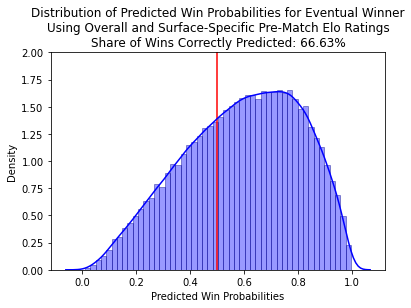

In [7]:
surface = matches["surface"]
p = 0.5

Winner_Rating = matches["PreMatchElo_Winner_All"]
Winner_Rating = np.where(surface=="Hard",p*matches["PreMatchElo_Winner_All"]+(1-p)*matches["PreMatchElo_Winner_Hard"],Winner_Rating)
Winner_Rating = np.where(surface=="Clay",p*matches["PreMatchElo_Winner_All"]+(1-p)*matches["PreMatchElo_Winner_Clay"],Winner_Rating)
Winner_Rating = np.where(surface=="Grass",p*matches["PreMatchElo_Winner_All"]+(1-p)*matches["PreMatchElo_Winner_Grass"],Winner_Rating)

Loser_Rating = matches["PreMatchElo_Loser_All"]
Loser_Rating = np.where(surface=="Hard",p*matches["PreMatchElo_Loser_All"]+(1-p)*matches["PreMatchElo_Loser_Hard"],Loser_Rating)
Loser_Rating = np.where(surface=="Clay",p*matches["PreMatchElo_Loser_All"]+(1-p)*matches["PreMatchElo_Loser_Clay"],Loser_Rating)
Loser_Rating = np.where(surface=="Grass",p*matches["PreMatchElo_Loser_All"]+(1-p)*matches["PreMatchElo_Loser_Grass"],Loser_Rating)

EloPredictions_SurfaceDependent = 1.0 / (1 + 10**((Loser_Rating - Winner_Rating) / 400))
EloPredictions_SurfaceDependent = pd.Series(EloPredictions_SurfaceDependent)

CorrectPct = round(EloPredictions_SurfaceDependent[EloPredictions_SurfaceDependent>0.5].count() / EloPredictions_SurfaceDependent.count()*100,2)
sns.distplot(EloPredictions_SurfaceDependent, hist=True, kde=True, bins=50, color = 'blue', hist_kws={'edgecolor':'darkblue'})
plt.vlines(0.5,0,2,colors="red")
plt.ylim(0,2)
plt.title("Distribution of Predicted Win Probabilities for Eventual Winner\nUsing Overall and Surface-Specific Pre-Match Elo Ratings\nShare of Wins Correctly Predicted: "+str(CorrectPct)+"%")
plt.xlabel("Predicted Win Probabilities")
plt.ylabel("Density")
plt.show()

**Create Head-to-Head Records**

We'll also add the head-to-head record for the players in each match. Note that most players have never played eachother. And that only very few have many matches against one another. So our expectations should be low for how much these two will matter. 

In [8]:
def head_to_head_wins(i):
  WID = int(matches[matches["MatchEloID"]==i]["winner_id"])
  LID = int(matches[matches["MatchEloID"]==i]["loser_id"])
  limited = all_matches[((all_matches["winner_id"]==WID) & (all_matches["loser_id"]==LID)) | 
                        ((all_matches["loser_id"]==WID) & (all_matches["winner_id"]==LID))]
  limited = limited[limited["MatchEloID"]<i]
  if limited.shape[0]>0:
    winner_head_to_head_wins = limited[(limited["winner_id"]==WID) & (limited["loser_id"]==LID)]
    loser_head_to_head_wins = limited[(limited["loser_id"]==WID) & (limited["winner_id"]==LID)]
    if winner_head_to_head_wins.shape[0]>0:
      matches.loc[matches["MatchEloID"]==i,["winner_head_to_head_wins"]] = winner_head_to_head_wins.shape[0]
    if loser_head_to_head_wins.shape[0]>0:
      matches.loc[matches["MatchEloID"]==i,["loser_head_to_head_wins"]] = loser_head_to_head_wins.shape[0]


In [9]:
matches["winner_head_to_head_wins"] = 0
matches["loser_head_to_head_wins"] = 0
for i in list(matches["MatchEloID"]):
  head_to_head_wins(int(i))

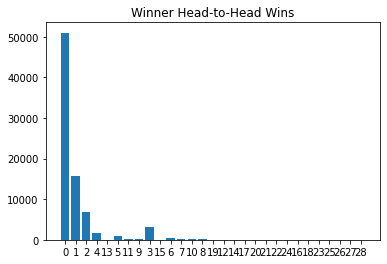

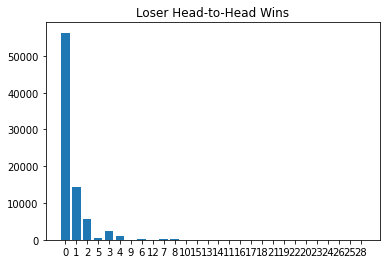

In [10]:
x = Counter(matches["winner_head_to_head_wins"])
plt.bar([str(i) for i in x.keys()], x.values())
plt.title("Winner Head-to-Head Wins")
plt.show()

x = Counter(matches["loser_head_to_head_wins"])
plt.bar([str(i) for i in x.keys()], x.values())
plt.title("Loser Head-to-Head Wins")
plt.show()

**Past Year Average Match Statistics**

I also attempted to create averages of the match level preformance statistics. However, the Google Colab runtime would disconnect before finishing. I'm hoping to circle back to this maybe with a Google Colab Pro account. 

In [ ]:
def resetPastYearStats():
  avgs = ['ace','df','svpt','1stIn','1stWon','2ndWon','SvGms','bpSaved','bpFaced']
  for col in avgs:
      matches['avg_w_'+col] = 0
  for col in avgs:
      matches['avg_l_'+col] = 0

In [ ]:
def past_year_stats(MatchID):

  #Pull winner and loser player IDs and teh match date (really the tournament date)
  WinnerID = int(matches[matches["MatchEloID"]==MatchID]["winner_id"])
  LoserID = int(matches[matches["MatchEloID"]==MatchID]["loser_id"])
  date = matches[matches["MatchEloID"]==MatchID]["date"]

  #pull to winners matches within a year of current match
  limited_winner = all_matches[(all_matches["winner_id"]==WinnerID) | (all_matches["loser_id"]==WinnerID)]
  limited_winner = limited_winner[(limited_winner["MatchEloID"]<MatchID)]
  limited_winner = limited_winner[list(limited_winner['date'].reset_index()["date"]>(date - datetime.timedelta(days=365)).repeat(limited_winner.shape[0]).reset_index()["date"])]

  #pull to losers matches within a year of current match
  limited_loser = all_matches[(all_matches["winner_id"]==LoserID) | (all_matches["loser_id"]==LoserID)]
  limited_loser = limited_loser[(limited_loser["MatchEloID"]<MatchID)]  
  limited_loser = limited_loser[list(limited_loser['date'].reset_index()["date"]>(date - datetime.timedelta(days=365)).repeat(limited_loser.shape[0]).reset_index()["date"])]

  #create list of match stats
  avgs = ['ace','df','svpt','1stIn','1stWon','2ndWon','SvGms','bpSaved','bpFaced']

  #for winners with matches within the last year
  if limited_winner.shape[0]>0:

    #pull match stats for all winner's wins
    limited_winner_wins = limited_winner[limited_winner["winner_id"]==WinnerID][['w_ace','w_df','w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpSaved','w_bpFaced']]
    names = [j.replace("w_", "avg_w_") for j in list(limited_winner_wins.columns)]
    limited_winner_wins = limited_winner_wins.rename(columns={list(limited_winner_wins.columns)[j]: names[j] for j in range(len(names))})
    
    #pull match stats for all winner's losses
    limited_winner_losses = limited_winner[limited_winner["loser_id"]==WinnerID][['l_ace','l_df','l_svpt','l_1stIn','l_1stWon','l_2ndWon','l_SvGms','l_bpSaved','l_bpFaced']]
    names = [j.replace("l_", "avg_w_") for j in list(limited_winner_losses.columns)]
    limited_winner_losses = limited_winner_losses.rename(columns={list(limited_winner_losses.columns)[j]: names[j] for j in range(len(names))})
    
    #stack the winner's wins and losses and 
    #calculate the mean across all the winner's matches for match stats
    limited_winner = pd.concat([limited_winner_wins,limited_winner_losses]).mean()

    #populate fields in matches data
    for col in avgs:
      matches.loc[matches["MatchEloID"]==MatchID,["avg_w_"+col]] = limited_winner["avg_w_"+col]

  #for losers with matches within the last year
  if limited_loser.shape[0]>0:

    #pull match stats for all loser's wins
    limited_loser_wins = limited_loser[limited_loser["winner_id"]==LoserID][['w_ace','w_df','w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpSaved','w_bpFaced']]
    names = [j.replace("w_", "avg_l_") for j in list(limited_loser_wins.columns)]
    limited_loser_wins = limited_loser_wins.rename(columns={list(limited_loser_wins.columns)[j]: names[j] for j in range(len(names))})
    
    #pull match stats for all loser's losses
    limited_loser_losses = limited_loser[limited_loser["loser_id"]==LoserID][['l_ace','l_df','l_svpt','l_1stIn','l_1stWon','l_2ndWon','l_SvGms','l_bpSaved','l_bpFaced']]
    names = [j.replace("l_", "avg_l_") for j in list(limited_loser_losses.columns)]
    limited_loser_losses = limited_loser_losses.rename(columns={list(limited_loser_losses.columns)[j]: names[j] for j in range(len(names))})
    
    #stack the loser's wins and losses and 
    #calculate the mean across all the loser's matches for match stats
    limited_loser = pd.concat([limited_loser_wins,limited_loser_losses]).mean()

    #populate fields in matches data
    for col in avgs:
      matches.loc[matches["MatchEloID"]==MatchID,["avg_l_"+col]] = limited_loser["avg_l_"+col]


In [ ]:
resetPastYearStats()
for i in list(matches["MatchEloID"]):
  past_year_stats(int(i))

**Logistic Regression**

We first expand on the Elo only based model by using the Elo ratings as explanatory features in a logistic regression model. 

The structure of our data is at the match level with columns for winner information and columns with loser information. So there is no outcome variable (i.e., win indicator) in the data as it currently stands. Given this set up, it wont be useful to just add a 1 to every row indicating that the winner won. Instead, we create two copies of the data - one as is and one with all the winner columns renamed to be called loser and all loser columns to be called winner. We can then add a win indicator to both copies where the indicator in the first copy is always 1 and in the second copy is always 0. Then we stack the two copies. 

So we give the learning algorithm each match twice: once where player A is in the "winner" columns and once where player B is in the "winner" columns. The algorithm will then learn to distinguish when a better player is in the "winner" columns and when one is it predicts a win. When one is not it predicts a loss. 

Another way to think of this is that the "winner" columns are really the "focus player" columns and the "loser" columns are the "opponent" columns. We're asking the algorithm to predict whether the focus player will win against the opponent. 

So the first thing to do is restructure the data as described.

In [11]:
wins = matches
losses = matches

names_code = [i.replace("winner", "WW").replace("Winner", "WWW").replace("w_", "WWWW").replace("loser", "LL").replace("Loser", "LLL").replace("l_", "LLLL") 
for i in list(losses.columns)]
names_rename = [i.replace("WWWW", "l_").replace("WWW", "Loser").replace("WW", "loser").replace("LLLL", "w_").replace("LLL", "Winner").replace("LL", "winner")
for i in names_code]
names_rename[0] = 'level_0'
losses = losses.rename(columns={names_rename[i]: list(losses.columns)[i] for i in range(len(names_rename))})
losses = losses[list(wins.columns)]

wins["win"] = 1
losses["win"] = 0

all = pd.concat([wins,losses])
all = all[all['winner_age'].notnull()]
all = all[all['loser_age'].notnull()]
all = all[all['winner_ht'].notnull()]
all = all[all['loser_ht'].notnull()]
all = pd.get_dummies(all, columns=['winner_hand','loser_hand','surface','best_of','round','tourney_level'])

Now we can use this restructured data to run some logistic regressions. 

- show how the logistic regression does with just ELos
- show how it does with all the native pre-match info
- show how it does with all the native pre-match info and the season statistics that we've calculated
- show how it does when you give it the statistics from the match but not the winner

We start with a version that just uses the overall Elo ratings for the winner and loser of each match. 

In [ ]:
X = all[['PreMatchElo_Winner_All','PreMatchElo_Loser_All']]
y = all[['win']]

clf = LogisticRegressionCV(cv=5, penalty='l2',random_state=0,max_iter=100000).fit(X, y)
LogitPredictions = clf.predict_proba(X)[0:int(all.shape[0]/2),1]
CorrectPct = round(clf.score(X, y)*100,2)

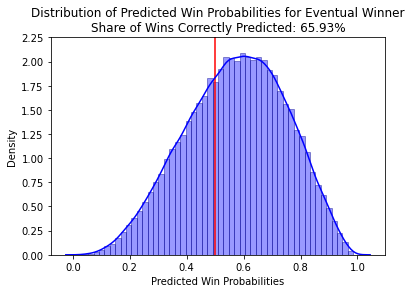

In [13]:
sns.distplot(LogitPredictions, hist=True, kde=True, bins=50, color = 'blue', hist_kws={'edgecolor':'darkblue'})
plt.vlines(0.5,0,3,colors="red")
plt.ylim(0,2.25)
plt.title("Distribution of Predicted Win Probabilities for Eventual Winner\nShare of Wins Correctly Predicted: "+str(CorrectPct)+"%")
plt.xlabel("Predicted Win Probabilities")
plt.ylabel("Density")
plt.show()

Next we run a version that also includes the surface-specific Elo ratings. 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


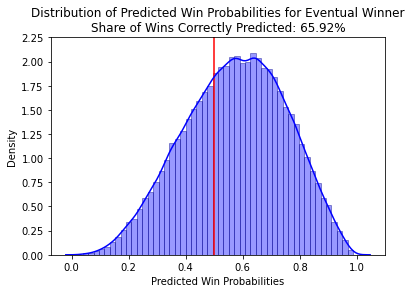

In [14]:
X = all[['PreMatchElo_Winner_All','PreMatchElo_Loser_All',
         'PreMatchElo_Winner_Grass','PreMatchElo_Loser_Grass',
         'PreMatchElo_Winner_Clay','PreMatchElo_Loser_Clay',
         'PreMatchElo_Winner_Hard','PreMatchElo_Loser_Hard']]
y = all[['win']]

clf = LogisticRegressionCV(cv=5, penalty='l2',random_state=0,max_iter=10000).fit(X, y)
LogitPredictions = clf.predict_proba(X)[0:int(all.shape[0]/2),1]
CorrectPct = round(clf.score(X, y)*100,2)

sns.distplot(LogitPredictions, hist=True, kde=True, bins=50, color = 'blue', hist_kws={'edgecolor':'darkblue'})
plt.vlines(0.5,0,3,colors="red")
plt.ylim(0,2.25)
plt.title("Distribution of Predicted Win Probabilities for Eventual Winner\nShare of Wins Correctly Predicted: "+str(CorrectPct)+"%")
plt.xlabel("Predicted Win Probabilities")
plt.ylabel("Density")
plt.show()

Next we run a version that also includes the pre-match information that is native in the data. 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


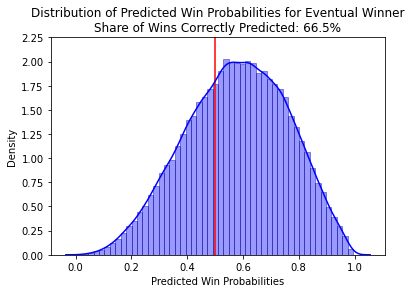

In [15]:
X = all[['PreMatchElo_Winner_All','PreMatchElo_Loser_All',
         'PreMatchElo_Winner_Grass','PreMatchElo_Loser_Grass',
         'PreMatchElo_Winner_Clay','PreMatchElo_Loser_Clay',
         'PreMatchElo_Winner_Hard','PreMatchElo_Loser_Hard',
         'winner_rank','winner_rank_points', 'loser_rank', 'loser_rank_points',
         'winner_hand_L', 'winner_hand_R', 
         'loser_hand_L', 'loser_hand_R', 
         'winner_ht', 'winner_age','loser_ht', 'loser_age',
         'draw_size',
         'surface_Carpet', 'surface_Clay', 'surface_Grass', 'surface_Hard', 
         'best_of_3', 'best_of_5', 'round_BR',  'round_F', 'round_QF', 
         'round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR', 'round_SF', 
         'tourney_level_A', 'tourney_level_F', 'tourney_level_G', 'tourney_level_M']]
y = all[['win']]

clf = LogisticRegressionCV(cv=5, penalty='l2',random_state=0,max_iter=10000).fit(X, y)
LogitPredictions = clf.predict_proba(X)[0:int(all.shape[0]/2),1]
CorrectPct = round(clf.score(X, y)*100,2)

sns.distplot(LogitPredictions, hist=True, kde=True, bins=50, color = 'blue', hist_kws={'edgecolor':'darkblue'})
plt.vlines(0.5,0,3,colors="red")
plt.ylim(0,2.25)
plt.title("Distribution of Predicted Win Probabilities for Eventual Winner\nShare of Wins Correctly Predicted: "+str(CorrectPct)+"%")
plt.xlabel("Predicted Win Probabilities")
plt.ylabel("Density")
plt.show()

Finally, we run a version that also includes the head-to-head record of the players in each match. 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


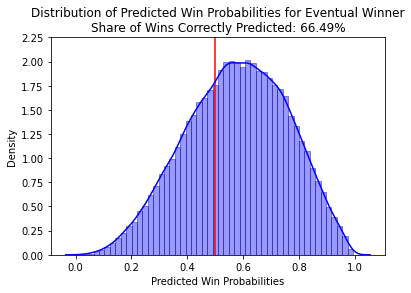

In [16]:
X = all[['PreMatchElo_Winner_All','PreMatchElo_Loser_All',
         'PreMatchElo_Winner_Grass','PreMatchElo_Loser_Grass',
         'PreMatchElo_Winner_Clay','PreMatchElo_Loser_Clay',
         'PreMatchElo_Winner_Hard','PreMatchElo_Loser_Hard',
         'loser_head_to_head_wins','winner_head_to_head_wins',
         'winner_rank','winner_rank_points', 'loser_rank', 'loser_rank_points',
         'winner_hand_L', 'winner_hand_R', 
         'loser_hand_L', 'loser_hand_R', 
         'winner_ht', 'winner_age','loser_ht', 'loser_age',
         'draw_size',
         'surface_Carpet', 'surface_Clay', 'surface_Grass', 'surface_Hard', 
         'best_of_3', 'best_of_5', 'round_BR',  'round_F', 'round_QF', 
         'round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR', 'round_SF', 
         'tourney_level_A', 'tourney_level_F', 'tourney_level_G', 'tourney_level_M']]
y = all[['win']]

clf = LogisticRegressionCV(cv=5, penalty='l2',random_state=0,max_iter=10000).fit(X, y)
LogitPredictions = clf.predict_proba(X)[0:int(all.shape[0]/2),1]
CorrectPct = round(clf.score(X, y)*100,2)

sns.distplot(LogitPredictions, hist=True, kde=True, bins=50, color = 'blue', hist_kws={'edgecolor':'darkblue'})
plt.vlines(0.5,0,3,colors="red")
plt.ylim(0,2.25)
plt.title("Distribution of Predicted Win Probabilities for Eventual Winner\nShare of Wins Correctly Predicted: "+str(CorrectPct)+"%")
plt.xlabel("Predicted Win Probabilities")
plt.ylabel("Density")
plt.show()

So far we've only barely beaten the simple overall Elo predictions and haven't bested the Elo predictions using the surface-specific ratings. We'll continute working!